# Energy balance for a laboratory equipment batch reactor for chemical synthesis

In this programming exercise you will also have from a chemical engineering point of view the task to develop the energy balance for a batch reactor. This is a task, we have not yet investigated in the lectures or group exercises. 
We consider the following Reaction taking place in a laboratory sized reactor using a liquid phase:

$A→B$

The setup is described in the following:
<img src="../../media/WS1/system.png" 
        alt="Picture" 
        width="500" 
        height="500" 
        style="display: block; margin: 0 auto" />

You can assume that the reaction order follows an elementary reaction and you have found in literature the rate velocity coefficient at 298 K to be 0.005 min-1. 
Please perform with help the following analysis:
1. Calculate the conversion and the Temperature as a function of time under the assumption that the reactor is operated under adiabatic conditions starting with a temperature of 298 K. 
2. Repeat the calculations for the heated reactor. Here the heating bed will generate a constant temperature of 398 K. Plot the conversion and temperature of the reactor as function of the time
3. Repeat the calculations for the reactor without reaction, in other words show how the reactor and the reactor mixture would behave as function of time assuming that no reaction takes place.


In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
#SI-units are used through the entire assigment
HA_298 = -622960
HB_298 = -380450
CA0 = 15
h1 = 0.05
h2 = 0.05
R_sphere = 0.1
E = 25000
R = 8.314
CPliq = 77
MWA = 0.28534
U1 = 40000
U2 = 5000
Ntot0 = 140
T0 = 298
k_298 = 0.005/60
#Volume of reactor is calculated:
V_reactor = 4/3*math.pi*R_sphere**3
#Half the reactor is filled with liquid, so:
V = 0.5*V_reactor
#From this the initial amount of A is found:
NA0 = CA0*V/MWA
print(NA0)
#NA0=52.5688
#A Stoiciometric table is made for the reaction
species = ["A","B", "I"]
start = ["N_{A0}", "0", "N_{I0}"]
coefficients = ["-1","1", "0"]
change = ["$$"+n+"* N_{A0}* X$$" for n in coefficients]
# If the start concentration is zero, the end flow is the same as the change in flow:
def endf(start,change,species,coefficients):
    end = [None] * len(start)
    for i in range(0,len(start)):
        if start[i] == "0":
            end[i] = change[i]
# If this is not the case, the end flow is the difference between start and change (were Theta_J = F_J0/F_A0)
        else:
            end[i] = "$$N_{A0}*(\u03F4_"+species[i]+"+"+"("+coefficients[i]+"* X))$$"
    return(end)
end = endf(start,change,species,coefficients)
#The stoichiometric table is setup in a pandas data frame
stoictable = pd.DataFrame(data={"Start":["$$"+i+"$$" for i in start], "Change":change, "End":end},  index=species)
stoictable

0.11009997384137497


,Start,Change,End
A,$$N_{A0}$$,$$-1* N_{A0}* X$$,$$N_{A0}*(ϴ_A+(-1* X))$$
B,$$0$$,$$1* N_{A0}* X$$,$$1* N_{A0}* X$$
I,$$N_{I0}$$,$$0* N_{A0}* X$$,$$N_{A0}*(ϴ_I+(0* X))$$


First the three solutions are plotted until conversion is close to 1:
Different time intervals are used for the first plot compared to the others


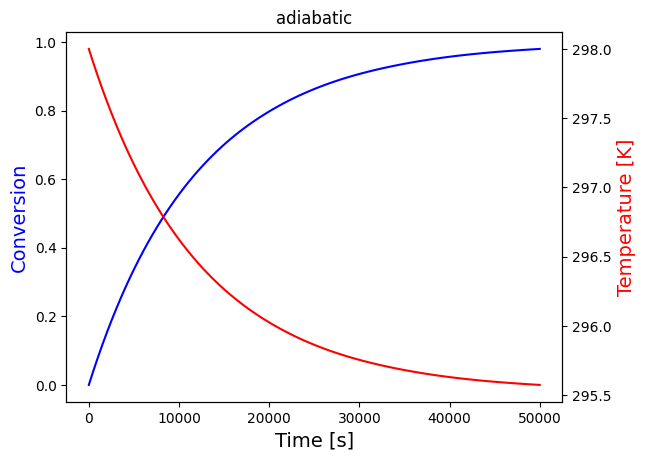

Since the heat of reaction is positive, heat is consumed by the reaction, so we expect temperature to drop in the adiabatic case, which is what is observed


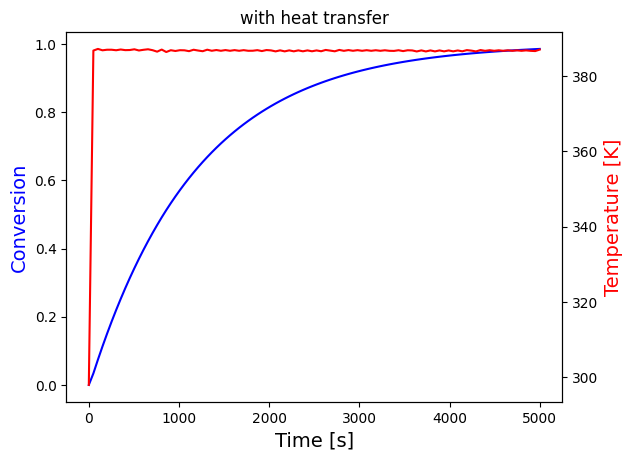

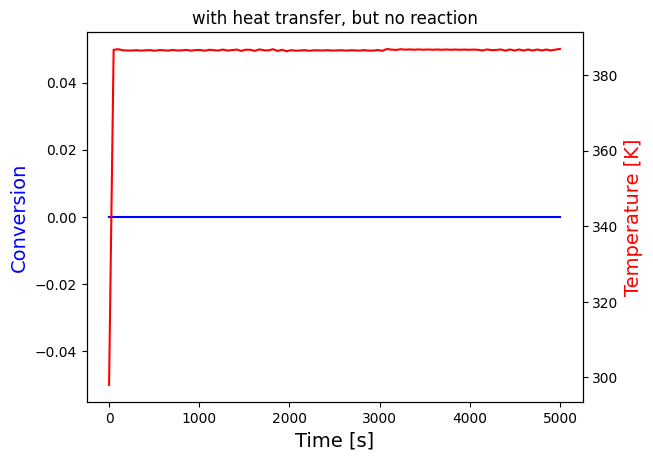

It's difficult to see what happens at the beginning for the last two plots, these are plotted again in a short interval


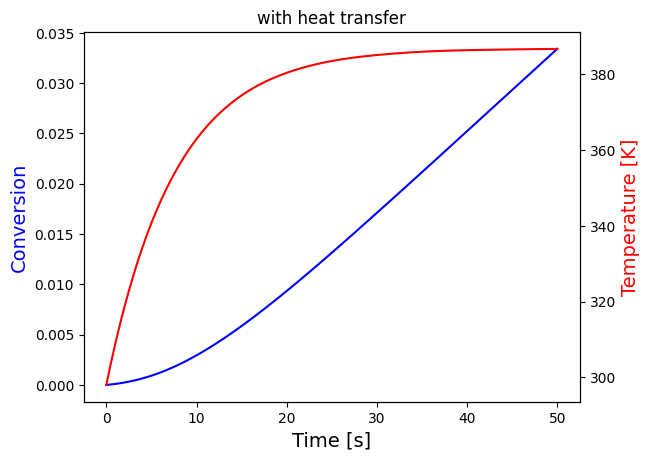

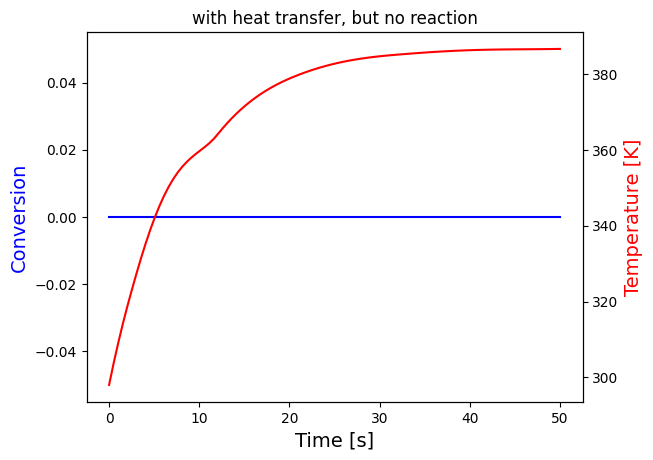

The temperature settles after around 60 seconds for both cases, which seems to be unreasonalably fast, probably because the heat transfer coefficients are very large
Nevertheless, it can be seen that the temperature growth is very similar in the last two cases this is because the heat of reaction is negligible compared to heat transfer
This is expected since the mol% of A in the reactor is very small: 0.079 i.e. less than 0.1%


In [2]:
#The expression for reaction rate is defined, the rate velocity coefficient is assumed to following Arrenhius' equation
#The equation found in the calculation sheet is used to define k at any temperature:
def k(k0,T0,T):
    return k0*math.exp(E/R*(1/T0-1/T))
#The reaction is elementary, so the reaction is first order. -r_a = kC_a, since volume is constant: C_a = N_a/V. We can now define the reaction rate in terms of X and T:
def r_a(X,T):
    return -k(k_298, 298, T)*NA0*(1-X)/V
#Now we can insert into the design equation for a batch reactor, defining our first differential equation:
def design_batch(X,T):
    return -r_a(X,T)*V/NA0
#Similar to what's done above, the different part sof the heat balance is defined in functions. The heat balance can be foundin the calculation sheet.
#Since no heat capacity for A and B is given, we assume that the enthalpy is constant, so the term DeltaHrx becomes:
Hrx = HB_298 - HA_298
#The heat capacity of the liquid is said to be constant, so this is easily defined:
CPs = CPliq
#Since the heat capacity is constant, we assume that DeltaC_p = 0
#The last term we need to define is Q, for this we use the overall heat transfer coefficient U
#We need to calculate the areas where heat transfer occurs. The area between the flask and heating block is:
A1 = 2*math.pi*R_sphere*h1
A2 = 2*math.pi*R_sphere**2 - 2*math.pi*R_sphere*h1
#Now the two heat transfers can be defined:
def Q(A,U,T0,T):
        return A*U*abs(T0-T)

#Now we define the system of differential equations for the three cases:
#For the adiabatic case heat transfer is zero, so Q = 0:
def adiabatic(t, z):
    X, T = z
    return [design_batch(X,T), ((-Hrx)*(-r_a(X,T))*V)/(Ntot0*CPs)]

#In the second case heat transfer is present:
def transfer(t, z):
    X, T = z
    return [design_batch(X,T), ((Q(A1,U1,398,T)-Q(A2,U2,298,T))-Hrx*(-r_a(X,T))*V)/(Ntot0*CPs)]

#In the last case no reaction takes place, so -r_a = 0
def no_reaction(t, z):
    X, T = z
    return [0, ((Q(A1,U1,398,T)-Q(A2,U2,298,T)))/(Ntot0*CPs)]

#A function solving the system of equations and plotting the result is defined:
def solve_and_plot_system(system, tspan, start, title):
    sol = solve_ivp(system, tspan, start, dense_output=True) # dense_output=True computes a continuous solution
    #generating t and solving the system of ODEs
    t = np.linspace(tspan[0],tspan[1], 100)
    z = sol.sol(t)
    
    # plotting the solution
    fig,ax = plt.subplots()
    ax.plot(t,z[0],color = "blue")
    ax.set_xlabel("Time [s]", fontsize =14)
    ax.set_ylabel("Conversion", color = "blue", fontsize =14)
    ax2=ax.twinx()
    ax2.plot(t,z[1],color = "red")
    ax2.set_ylabel("Temperature [K]",color = "red", fontsize =14)
    plt.title(title)
    plt.show()
   

# The three systems are solved, and their solutions are plotted
print("First the three solutions are plotted until conversion is close to 1:")
print("Different time intervals are used for the first plot compared to the others")
solve_and_plot_system(adiabatic, [0,50000], [0,298], "adiabatic")
print("Since the heat of reaction is positive, heat is consumed by the reaction, so we expect temperature to drop in the adiabatic case, which is what is observed")
solve_and_plot_system(transfer, [0,5000], [0,298], "with heat transfer")
solve_and_plot_system(no_reaction, [0,5000], [0,298], "with heat transfer, but no reaction")
print("It's difficult to see what happens at the beginning for the last two plots, these are plotted again in a short interval")
solve_and_plot_system(transfer, [0,50], [0,298], "with heat transfer")
solve_and_plot_system(no_reaction, [0,50], [0,298], "with heat transfer, but no reaction")
print("The temperature settles after around 60 seconds for both cases, which seems to be unreasonalably fast, probably because the heat transfer coefficients are very large")
print("Nevertheless, it can be seen that the temperature growth is very similar in the last two cases this is because the heat of reaction is negligible compared to heat transfer")
print("This is expected since the mol% of A in the reactor is very small:",round(NA0/Ntot0*100,3), "i.e. less than 0.1%")

In [3]:
print(A1, A2)

0.031415926535897934 0.031415926535897934


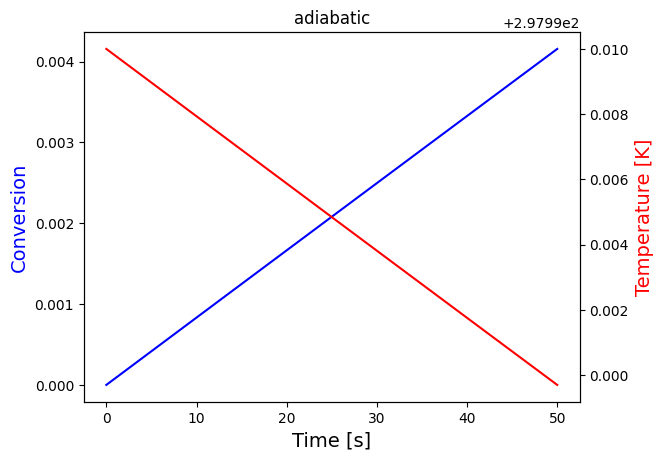

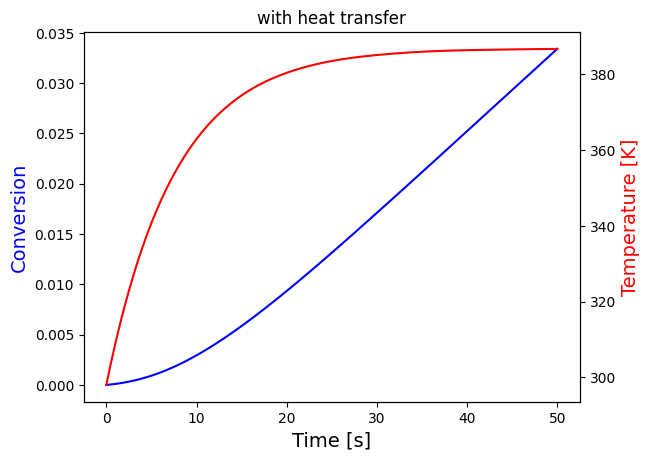

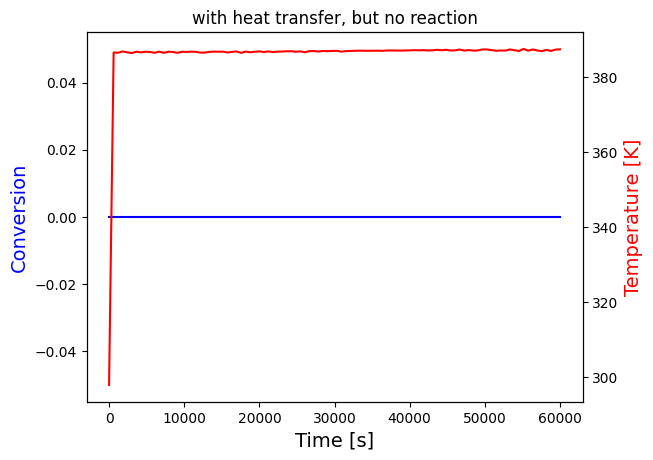

In [4]:
solve_and_plot_system(adiabatic, [0,50], [0,298], "adiabatic")
solve_and_plot_system(transfer, [0,50], [0,298], "with heat transfer")
solve_and_plot_system(no_reaction, [0,60000], [0,298], "with heat transfer, but no reaction")